In [1]:
import numpy as np
import pandas as pd
import torch
import h5py
import re
import torch.nn as nn 
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [3]:

### 14 Feb with window resizing of 300 values

## Iterating over the smoke detecotrs which are defined as list and loop through the file all over lines and getting the current window size 
#### and get the time values for 300 steps - density values over time of 300 are stored in  "density_values_tensor" 
#### and source values for each iteration are stored in "source_positions_tensor"

smoke_detectors = np.array([[60.0, 60.0],[30.0, 80.0]])

# Initialize lists to store tensors for source positions and density values
source_positions_tensors = []
density_values_tensors = []
# Initialize tensors for source positions and density values
source_positions_tensor = None
density_values_tensor = None


# Open the HDF5 file in read mode
with h5py.File("Smoke Flow Data.h5", "r") as hf:
    

    # Iterate over each smoke detector position
    for smoke_detector_pos in smoke_detectors:
        x, y = smoke_detector_pos
        
        # Iterate over the time steps with a sliding window
        # for start_idx in range(total_steps - window_size):
        for idx, source_group_name in enumerate(hf):
            total_steps = 501  # Total number of steps
            window_size = 300
            step_size = 1
            # Access the group corresponding to the source position
            # for source_group_name in hf.keys():
            for start_idx in range(total_steps - window_size):
                source_group = hf[source_group_name]

                # Extract the source position value from the group name
                source_position_str = source_group_name.split('-')[-1]

                # Convert the source position string to a numerical data type (e.g., float)
                source_position = float(source_position_str)

                # Access the 'density' dataset within the group
                density_dataset = source_group['density']

                # Retrieve the density values at the specified position (x, y) for the current window
                density_values_at_position = density_dataset[start_idx : start_idx + window_size, int(x), int(y), 0]
                # print(start_idx,  start_idx + window_size)

                # Convert density values to PyTorch tensor
                density_values_tensor_batch = torch.tensor(density_values_at_position)
                source_position_tensor_batch = torch.tensor(source_position)

                if source_positions_tensor is None:
                    source_positions_tensor = source_position_tensor_batch.unsqueeze(0)
                    density_values_tensor = density_values_tensor_batch.unsqueeze(0)
                else:
                    source_positions_tensor = torch.cat((source_positions_tensor, source_position_tensor_batch.unsqueeze(0)), dim=0)
                    density_values_tensor = torch.cat((density_values_tensor, density_values_tensor_batch.unsqueeze(0)), dim=0)
                    # print("Density values tensor shape 0:", density_values_tensor.shape)


            # Append the tensors to the lists after processing all sliding windows
            # print("Density values tensor shape 1:", density_values_tensor.shape)
            source_positions_tensors.append(source_positions_tensor)
            density_values_tensors.append(density_values_tensor)


# You now have the source positions and density values as tensors with sliding windows
print("Source positions tensor shape:", source_positions_tensor.shape)
print("Density values tensor shape:", density_values_tensor.shape)


##### number of sources are 9 
##each source with window size of 300 has 201 values right - for 9 its 1809 
### for 2 smoke detectords : 3618

#### for better unnderstanding uncomment the print statements




Source positions tensor shape: torch.Size([3618])
Density values tensor shape: torch.Size([3618, 300])


In [4]:
#### The size of source and density for two smoke detecors are 3818 - so viewing as colors channels
#### and named as density_tensor and source_tensor

density_tensor = density_values_tensor.view(1809,2,-1)
source_tensor = source_positions_tensor.reshape(1809,-1)

In [5]:
print("Source positions tensor shape:", source_tensor.shape)
print("Density values tensor shape:", density_tensor.shape)

Source positions tensor shape: torch.Size([1809, 2])
Density values tensor shape: torch.Size([1809, 2, 300])


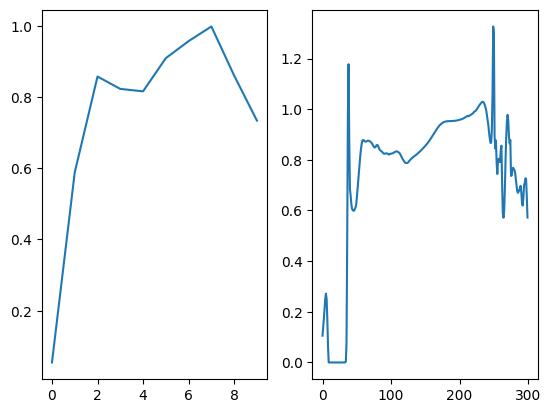

In [24]:
### Just checking how averaging might work on the singal
index = 200; sensor = 0
# import torch.nn as nn
my_test_layer = nn.AvgPool1d(30)
plt.subplot(121)
plt.plot(my_test_layer(density_tensor)[index,sensor,:])
plt.subplot(122)
plt.plot((density_tensor)[index,sensor,:])



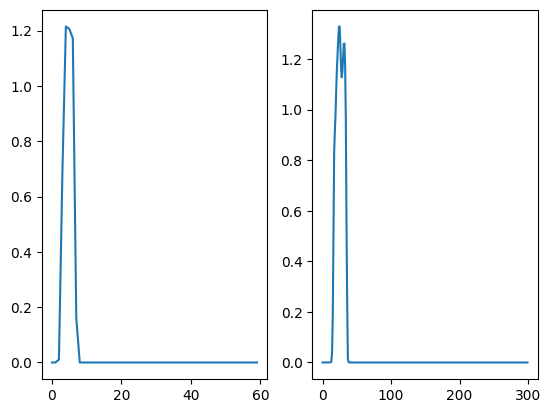

In [7]:
## Just checking how averaging might work on the singal
my_test_layer1 = nn.AvgPool1d(5)
plt.subplot(121)
plt.plot(my_test_layer1(density_tensor)[4,0,:])
plt.subplot(122)
plt.plot((density_tensor)[4,0,:])

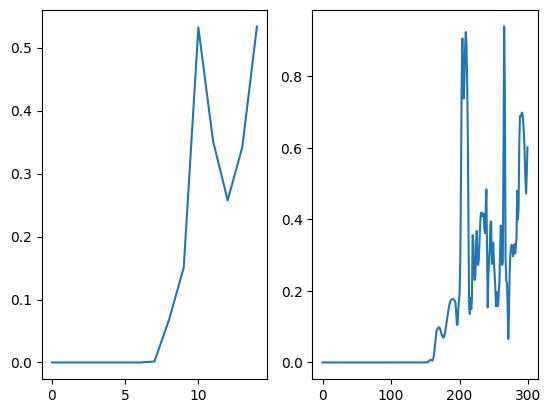

In [169]:
## Just checking how averaging might work on the singalf
my_test_layer2 = nn.AvgPool1d(20)
plt.subplot(121)
plt.plot(my_test_layer2(density_tensor)[400,0,:])
plt.subplot(122)
plt.plot((density_tensor)[400,0,:])



In [71]:
# Assuming you have separate training and testing datasets
## Split 80 train - 20 test

num_samples = len(density_tensor)
split_ratio = 0.8
split_index = int(split_ratio * num_samples)

In [72]:
train_density = density_tensor[:split_index]
test_density = density_tensor[split_index:]
train_source = source_tensor[:split_index]
test_source = source_tensor[split_index:]

In [52]:
batch_size = 64

# Create DataLoader for training set
train_dataset = TensorDataset(train_density, train_source)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing set
test_dataset = TensorDataset(test_density, test_source)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [182]:
class SimpleCNN(nn.Module):
    def __init__(self, debug=0):
        super(SimpleCNN, self).__init__()

        self.debug = debug
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        
        self.avgpool1 = nn.AvgPool1d(10)  # Adjusted kernel size and stride to produce same-length outputs
        self.avgpool2 = nn.AvgPool1d(6)  # Adjusted kernel size and stride to produce same-length outputs
        self.avgpool3 = nn.AvgPool1d(5)  # Adjusted kernel size and stride to produce same-length outputs
        
        self.flatten = nn.Flatten()
        
        self.linear_layer = nn.Linear(1120, 1)  # Adjusted based on the number of output channels and pooling sizes

    def forward(self, x):
        # Apply the average pooling layers
        x1 = self.avgpool1(x)
        if self.debug:
            print("Size before reshaping 1:", x1.size())
        x2 = self.avgpool2(x)
        if self.debug:
            print("Size before reshaping 2:", x2.size())
        x3 = self.avgpool3(x)
        if self.debug:
            print("Size before reshaping 3:", x3.size())

        # Concatenate the outputs from the average pooling layers
        x_concat = torch.cat((x1, x2, x3),dim = 2)
        if self.debug:
            print("Size before reshaping final concated:", x_concat.size())

        # Apply the first convolutional layer
        x_concat = self.conv1(x_concat)
        x_concat = self.relu1(x_concat)

        # Apply the second convolutional layer
        x_concat = self.conv2(x_concat)
        x_concat = self.relu2(x_concat)
        
        # Apply the third convolutional layer
        x_concat = self.conv3(x_concat)
        x_concat = self.relu3(x_concat)

        # Apply the fourth convolutional layer
        x_concat = self.conv4(x_concat)
        x_concat = self.relu4(x_concat)

        if self.debug:
            print("size before conv1d",x_concat.size())

        # Flatten the output tensor
        x_concat = self.flatten(x_concat)

        if self.debug:
            print("size after conv1d flatten",x_concat.size())
        
        # Apply the linear layer for regression
        x_concat = self.linear_layer(x_concat)

        if self.debug:
            print(x_concat.size())

        return x_concat


In [183]:
# Create an instance of the model
debug_mode = False
model = SimpleCNN(debug=debug_mode)

## List for loss
train_losses = []
test_losses = []

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [184]:
# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    for density_batch, source_batch in train_loader:
        # # Forward pass
        # print(density_batch.shape)
        outputs = model(density_batch)

        # print(outputs.shape, source_batch.shape)

        # Compute loss
        loss = criterion(outputs, source_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate scheduler step
    # scheduler.step()
    
    if epoch % 2 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item()}')

# Testing loop
    model.eval()
with torch.no_grad():
    for density_batch, source_batch in test_loader:
        test_outputs = model(density_batch)
        test_loss = criterion(test_outputs, source_batch)
        

# After training and testing, you can use the model to make predictions
predicted_sources = model(density_tensor)

Epoch [0/100], Loss: 898.0505981445312
Epoch [2/100], Loss: 653.9982299804688
Epoch [4/100], Loss: 437.4110107421875
Epoch [6/100], Loss: 274.7010803222656
Epoch [8/100], Loss: 297.033203125
Epoch [10/100], Loss: 186.5607452392578
Epoch [12/100], Loss: 329.69183349609375
Epoch [14/100], Loss: 304.5930480957031
Epoch [16/100], Loss: 181.53518676757812
Epoch [18/100], Loss: 219.1623077392578
Epoch [20/100], Loss: 184.22311401367188
Epoch [22/100], Loss: 239.92051696777344
Epoch [24/100], Loss: 165.0729217529297
Epoch [26/100], Loss: 110.34683227539062
Epoch [28/100], Loss: 145.98622131347656
Epoch [30/100], Loss: 78.54788970947266
Epoch [32/100], Loss: 159.60682678222656
Epoch [34/100], Loss: 205.60098266601562
Epoch [36/100], Loss: 94.7618179321289
Epoch [38/100], Loss: 110.23381042480469
Epoch [40/100], Loss: 159.8650665283203
Epoch [42/100], Loss: 56.1640510559082
Epoch [44/100], Loss: 94.80886840820312
Epoch [46/100], Loss: 154.96914672851562
Epoch [48/100], Loss: 70.31195831298828
E

In [139]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

2005

In [ ]:
### Testing

In [3]:
# #### 14 Feb - rewrote the code - normal operations performance for entire window size

# smoke_detectors = np.array([[60.0, 60.0],[30.0, 80.0]])

# # Initialize tensors for source positions and density values
# source_positions_tensor = None
# density_values_tensor = None

# # Open the HDF5 file in read mode
# with h5py.File("Smoke Flow Data.h5", "r") as hf:
#     # Iterate over each source position group in the HDF5 fileab
#     for smoke_detector_pos in smoke_detectors:
#         x, y = smoke_detector_pos
    
#         for idx, source_group_name in enumerate(hf):
#             # Access the group corresponding to the source position
#             source_group = hf[source_group_name]
            
#             # Extract the source position value from the group name
#             source_position_str = source_group_name.split('-')[-1]
            
#             # Convert the source position string to a numerical data type (e.g., float)
#             source_position = float(source_position_str)
    
#             # Access the 'density' dataset within the group
#             density_dataset = source_group['density']
            
#             # Retrieve the density values at the specified position (x, y) for all time steps
#             density_values_at_position = density_dataset[:, int(x), int(y), 0]
            
#             # Convert density values to PyTorch tensor
#             density_values_tensor_batch = torch.tensor(density_values_at_position)
#             source_position_tensor_batch = torch.tensor(source_position)
            
#             # Concatenate or stack tensors along a new dimension
#             if source_positions_tensor is None:
#                 source_positions_tensor = source_position_tensor_batch.unsqueeze(0)
#                 density_values_tensor = density_values_tensor_batch.unsqueeze(0)
#             else:
#                 source_positions_tensor = torch.cat((source_positions_tensor, source_position_tensor_batch.unsqueeze(0)), dim=0)
#                 density_values_tensor = torch.cat((density_values_tensor, density_values_tensor_batch.unsqueeze(0)), dim=0)

# # You now have the source positions and density values as tensors
# print("Source positions tensor shape:", source_positions_tensor.shape)
# print("Density values tensor shape:", density_values_tensor.shape)


Source positions tensor shape: torch.Size([18])
Density values tensor shape: torch.Size([18, 501])


In [4]:
# density_tensor = density_values_tensor.view(9,2,-1)
# source_tensor = source_positions_tensor.reshape(9,-1)

In [7]:
# print("Source positions tensor shape:", source_tensor.shape)
# print("Density values tensor shape:", density_tensor.shape)

Source positions tensor shape: torch.Size([9, 2])
Density values tensor shape: torch.Size([9, 2, 501])


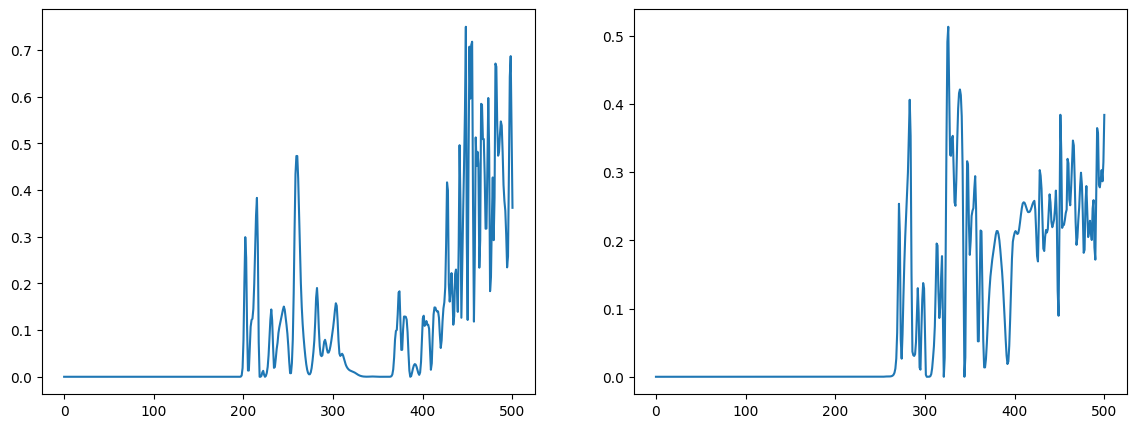

In [10]:
# fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# axes[0].plot(density_tensor[2, 0, :], label='Set 1')
# axes[1].plot(density_tensor[2, 1, :], label='Set 2')


In [122]:
# import torch
# import torch.nn as nn

# class SimpleCNN(nn.Module):
#     def __init__(self, debug=0):
#         super(SimpleCNN, self).__init__()

#         self.debug = debug
#         self.conv1 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=1)
#         self.relu1 = nn.ReLU()
        
#         self.conv2 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
#         self.relu2 = nn.ReLU()
#         self.conv3 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1)
#         self.relu3 = nn.ReLU()
#         self.conv4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
#         self.relu4 = nn.ReLU()
        
#         self.avgpool1 = nn.AvgPool1d(10)  # Adjusted kernel size and stride to produce same-length outputs
#         self.avgpool2 = nn.AvgPool1d(6)  # Adjusted kernel size and stride to produce same-length outputs
#         self.avgpool3 = nn.AvgPool1d(60)  # Adjusted kernel size and stride to produce same-length outputs
        
#         self.flatten = nn.Flatten()
        
#         self.linear_layer = nn.Linear(688, 1)  # Adjusted based on the number of output channels and pooling sizes

#     def forward(self, x):
#         # Apply the average pooling layers
#         x1 = self.avgpool1(x)
#         # print("Size before reshaping 1:", x1.size())
#         x2 = self.avgpool2(x)
#         # print("Size before reshaping 2:", x2.size())
#         x3 = self.avgpool3(x)
#         # print("Size before reshaping 3:", x3.size())

#         # Concatenate the outputs from the average pooling layers
#         x_concat = torch.cat((x1, x2, x3),dim = 2)
#         # print("Size before reshaping final concated:", x_concat.size())

#         # Apply the first convolutional layer
#         x_concat = self.conv1(x_concat)
#         x_concat = self.relu1(x_concat)

#         # Apply the second convolutional layer
#         x_concat = self.conv2(x_concat)
#         x_concat = self.relu2(x_concat)
        
#         # Apply the third convolutional layer
#         x_concat = self.conv3(x_concat)
#         x_concat = self.relu3(x_concat)

#         # Apply the fourth convolutional layer
#         x_concat = self.conv4(x_concat)
#         x_concat = self.relu4(x_concat)

#         # print("size before conv1d",x_concat.size())

#         # Flatten the output tensor
#         x_concat = self.flatten(x_concat)

#         # print("size after conv1d flatten",x_concat.size())
#         # Apply the linear layer for regression
#         x_concat = self.linear_layer(x_concat)

#         # print(x_concat.size())

#         return x_concat
 


